In [1]:

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex

In [4]:
#https://finance.yahoo.com/quote/AAPL?ltr=1

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
tickers=pd.DataFrame(get_symbols())
tickers.head()

tickers = ["SPY", "AGG"]
end_date = datetime.now()
start_date = end_date + timedelta(-1825)
port_planner_df = get_historical_data(tickers, start_date, end_date,  output_format='pandas')
port_planner_df.head()
#port_planner_df = pd.DataFrame('API_Port_Planner_Homework.pickle')
#port_planner_df.to_pickle('API_Port_Planner_Homework.pickle')
#port_planner_df.read_pickle('API_Port_Planner_Homework.pickle')

SPY                                        AGG                  \
              open    high     low   close     volume    open    high     low   
date                                                                            
2015-01-29  200.38  202.30  198.68  201.99  173585424  111.93  112.06  111.82   
2015-01-30  200.57  202.17  199.13  199.45  197729724  112.35  112.52  112.24   
2015-02-02  200.05  202.03  197.86  201.92  163106969  112.06  112.23  112.00   
2015-02-03  203.00  204.85  202.55  204.84  124212881  112.10  112.10  111.76   
2015-02-04  203.92  205.38  203.51  204.06  134306728  111.64  111.95  111.50   

                             
             close   volume  
date                         
2015-01-29  111.98  1752591  
2015-01-30  112.38  6252828  
2015-02-02  112.20  2792120  
2015-02-03  111.77  1815375  
2015-02-04  111.94  1953033

In [6]:
#Drop extraneous columns
port_planner_df.drop(columns=['open', 'low', 'volume', 'high'], level=1, inplace=True)
port_planner_df.head()

,SPY,AGG
,close,close
date,,
2015-01-29,201.99,111.98
2015-01-30,199.45,112.38
2015-02-02,201.92,112.20
2015-02-03,204.84,111.77
2015-02-04,204.06,111.94


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [7]:
daily_returns_df = port_planner_df.pct_change()
daily_returns_df.head()

,SPY,AGG
,close,close
date,,
2015-01-29,NaN,NaN
2015-01-30,-0.012575,0.003572
2015-02-02,0.012384,-0.001602
2015-02-03,0.014461,-0.003832
2015-02-04,-0.003808,0.001521


In [8]:
# Cumulative Returns for each name
#cumulative_returns_df = (1 + daily_returns_df.fillna(0)).cumprod()
#cumulative_returns_df.head()

In [9]:
# Calculate the mean of average daily returns
avg_daily_return_spy = daily_returns_df.mean()['SPY']['close']
avg_daily_return_agg = daily_returns_df.mean()['AGG']['close']
avg_daily_return_spy

0.000410825337024575

In [10]:
# Calculate STD Deviations
std_dev_daily_return_spy = daily_returns_df.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns_df.std()['AGG']['close']
std_dev_daily_return_spy

0.008450669532050302

In [11]:
# Set number of simulations and trading days
num_simulations = 500
num_trading_days = 252 * 30

# Set last closing prices of `SPY` and `AGG`
spy_last_price = port_planner_df['SPY']['close'][-1]
agg_last_price = port_planner_df['AGG']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `500` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002660,0.995149,0.992572,0.999214,1.005409,1.007140,1.009749,0.995495,1.001605,0.998888,...,1.001916,0.995278,1.007386,0.999621,0.997292,1.002912,0.995607,0.993012,1.003015,0.996953
2,1.007444,0.998899,0.991413,0.998023,1.008634,0.997151,1.003581,0.984007,1.000452,1.007626,...,1.003777,1.002761,1.010361,1.001006,0.998481,0.999463,0.994754,0.993226,1.002666,1.000585
3,1.006312,0.998661,0.994870,0.991514,1.007673,1.000269,1.007345,0.977448,0.999923,1.015917,...,1.003498,1.005494,1.015040,1.002213,0.991239,0.997787,0.998327,0.999045,1.005921,0.998950
4,1.015251,1.001416,0.990676,0.997334,1.008865,0.994574,1.005633,0.974331,1.008022,1.004692,...,1.005276,1.003220,1.013204,1.007554,0.997496,0.994307,0.992082,0.999447,1.010518,1.002385


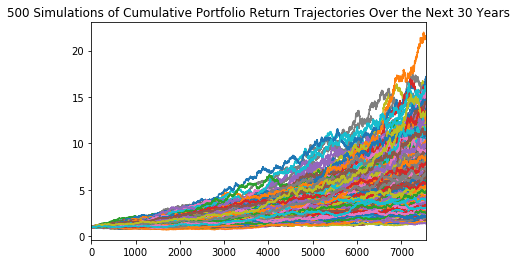

In [12]:
# Plot Graphs
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [13]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    7.172163
1    5.838386
2    8.199224
3    8.701686
4    7.809889
Name: 7560, dtype: float64

In [14]:
# Use the `value_counts` function and the `len` function to calculate the probabilities of cumulative return ranges
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(5.325, 7.311]      0.308
(3.338, 5.325]      0.284
(7.311, 9.298]      0.178
(1.33, 3.338]       0.082
(9.298, 11.285]     0.068
(11.285, 13.271]    0.040
(13.271, 15.258]    0.026
(15.258, 17.245]    0.012
(19.232, 21.218]    0.002
(17.245, 19.232]    0.000
Name: 7560, dtype: float64

In [15]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05     2.818987
0.95    12.422994
Name: 7560, dtype: float64

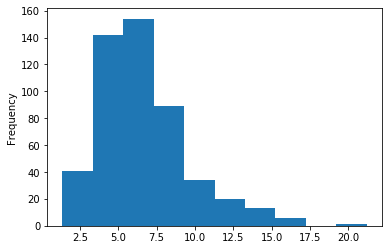

In [16]:
# Display the 95% confidence interval for the ending returns
ending_cumulative_returns.plot(kind='hist', bins=10)

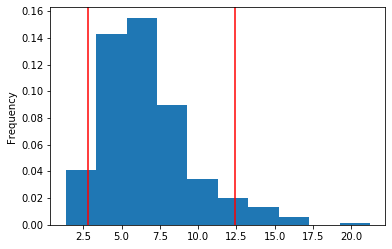

In [17]:
 # Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

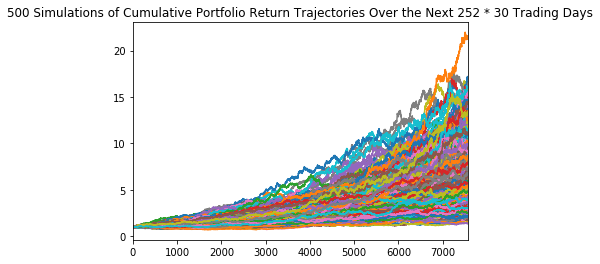

In [18]:
# Visualize the distribution of the ending returns
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 * 30 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [19]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# Set number of simulations and trading days
num_simulations = 500
num_trading_days = 252 * 20

# Set last closing prices of `SPY` and `AGG`
spy_last_price = port_planner_df['SPY']['close'][-1]
agg_last_price = port_planner_df['AGG']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns_20 = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `500` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    
    # Simulate the returns for 252 * 20 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns_20[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns_20.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001283,0.988944,1.000715,0.995705,0.995299,1.008893,1.003534,0.993285,1.006380,0.998786,...,0.997050,1.005105,0.989215,1.000133,0.993412,0.998328,0.995617,0.996955,0.996488,0.990158
2,0.997807,0.993603,0.999268,0.993226,0.993121,1.010252,1.011532,0.988109,1.018141,0.995183,...,0.993882,1.000254,0.985511,1.000553,0.985499,1.000347,0.988866,0.995935,0.994308,0.985994
3,0.995601,0.996319,1.000762,0.992183,0.994130,1.001297,1.011340,0.996785,1.016562,0.999099,...,0.991643,0.997419,0.980981,1.000225,0.986201,1.013642,0.987082,0.988523,0.994298,0.992043
4,0.997886,0.994500,1.005914,0.997719,0.986019,1.003472,1.011167,0.999555,1.012771,0.999507,...,0.994167,1.001865,0.982297,1.003546,0.983409,1.008359,0.990139,0.993130,0.992516,1.004672


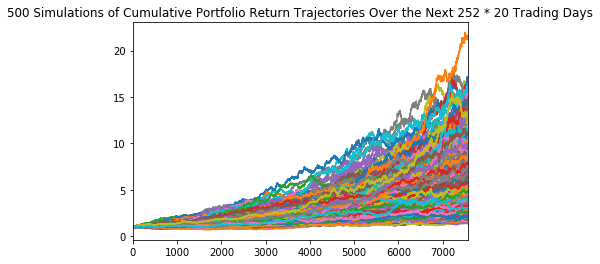

In [20]:
# Visualize the distribution of the ending returns
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 * 20 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [21]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# Set number of simulations and trading days
num_simulations = 500
num_trading_days = 252

# Set last closing prices of `SPY` and `AGG`
spy_last_price = port_planner_df['SPY']['close'][-1]
agg_last_price = port_planner_df['AGG']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns_5 = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `500` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    
    # Simulate the returns for 252
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns_5[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns_5.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008128,0.993377,1.002433,1.005509,0.995103,0.993665,0.992805,1.002601,1.008902,0.996477,...,0.997333,1.000446,0.996006,1.001016,1.000846,0.994657,0.994537,0.999489,1.007534,0.994156
2,1.009469,0.996090,1.004194,1.000956,0.999189,0.991263,0.999351,1.007644,1.007787,1.006185,...,0.997102,1.004110,0.997619,0.996831,0.998538,0.995401,0.987797,0.996273,1.005992,0.995172
3,1.016188,0.988091,1.007362,0.997227,0.994015,0.989139,0.997325,1.011481,1.009885,1.007108,...,0.989002,1.000888,0.991265,0.992974,0.992902,0.990908,0.991419,1.000211,1.008466,0.993352
4,1.028010,0.991846,1.003893,1.010366,0.990210,0.987732,0.992861,1.006877,1.017905,1.006256,...,0.988152,0.996895,0.998504,0.994978,0.991028,0.992254,0.986449,1.008501,1.007364,0.994597


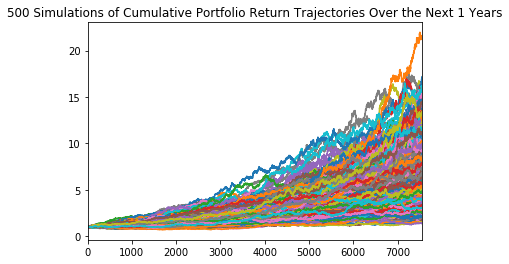

In [22]:
# Visualize the distribution of the ending returns 1 years
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 1 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [23]:
#Confidence interval 10th percentile 
confidence_interval_10 = ending_cumulative_returns.quantile(q=[0.90, 0.10])
confidence_interval_10

0.9    10.315029
0.1     3.547277
Name: 7560, dtype: float64

In [24]:
#Confidence interval 50th percentile 
confidence_interval_50 = ending_cumulative_returns.quantile(q=[0.50, 0.50])
confidence_interval_50

0.5    5.981518
0.5    5.981518
Name: 7560, dtype: float64

In [25]:
#Confidence interval 90th percentile 
confidence_interval_90 = ending_cumulative_returns.quantile(q=[0.10, 0.90])
confidence_interval_90

0.1     3.547277
0.9    10.315029
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [26]:
# Set Initial Investment of $20,000
initial_investment = 20000
# Confidence Interval 10th Percentile
investment_pnl_lower_bound = initial_investment * confidence_interval_10.iloc[0]
investment_pnl_upper_bound = initial_investment * confidence_interval_10.iloc[1]
print(f"There is a 10% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 252 * 30 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 10% chance that an initial investment of $20,000 in the portfolio over the next 252 * 30 trading days will end within in the range of $206300.58172301744 and $70945.54951351283


In [27]:
# Confidence Interval 50th Percentile
investment_pnl_lower_bound = initial_investment * confidence_interval_50.iloc[0]
investment_pnl_upper_bound = initial_investment * confidence_interval_50.iloc[1]
print(f"There is a 50% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 252 * 30 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 50% chance that an initial investment of $20,000 in the portfolio over the next 252 * 30 trading days will end within in the range of $119630.35659326396 and $119630.35659326396


In [28]:
# Confidence Interval 90th Percentile
investment_pnl_lower_bound = initial_investment * confidence_interval_90.iloc[0]
investment_pnl_upper_bound = initial_investment * confidence_interval_90.iloc[1]
print(f"There is a 90% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 252 * 30 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 90% chance that an initial investment of $20,000 in the portfolio over the next 252 * 30 trading days will end within in the range of $70945.54951351283 and $206300.58172301744


In [31]:
# Confidence Interval 90th Percentile @ $40,000
initial_investment = 40000
investment_pnl_lower_bound = initial_investment * confidence_interval_90.iloc[0]
investment_pnl_upper_bound = initial_investment * confidence_interval_90.iloc[1]
print(f"There is a 90% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 252 * 30 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 90% chance that an initial investment of $20,000 in the portfolio over the next 252 * 30 trading days will end within in the range of $141891.09902702566 and $412601.1634460349


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [34]:
# YOUR CODE HERE
projected_income_yearly = 6085
retirement_value = 77064
withdraw_rate = .04

def retirement_status():
    if withdraw_value >= income_yearly:
        print(f"The ${withdraw_value} is greater than your yearly income of ${income_yearly}, so you are good to go on retirement, enjoy")
    else: 
        print(f"The ${withdraw_value} is less than your yearly income of ${income_yearly} you need to keep working hard my friend!")
withdraw_value = (retirement_value * withdraw_rate)

retirement_status()

The $3082.56 is less than your yearly income of $7389 you need to keep working hard my friend!


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [35]:
# Ran Scenario few lines up on 50,000
income_yearly = 6085
retirement_value = 141891
withdraw_rate = .04

def retirement_status():
    if withdraw_value >= income_yearly:
        print(f"The ${withdraw_value} is greater than your yearly income of ${income_yearly}, so you are good to go on retirement, enjoy")
    else: 
        print(f"The ${withdraw_value} is less than your yearly income of ${income_yearly} you need to keep working hard my friend!")
withdraw_value = (retirement_value * withdraw_rate)

retirement_status()

The $5675.64 is less than your yearly income of $6085 you need to keep working hard my friend!


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

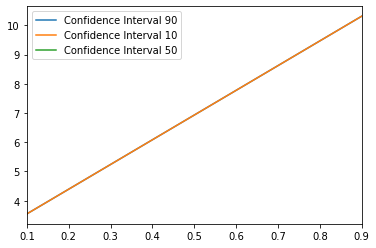

In [49]:
ax=confidence_interval_90.plot()
confidence_interval_10.plot(ax=ax)
confidence_interval_50.plot(ax=ax)
ax.legend(['Confidence Interval 90', 'Confidence Interval 10', 'Confidence Interval 50']);




In [52]:
investment_pnl_lower_bound_50 = initial_investment * confidence_interval_50.iloc[0]
investment_pnl_upper_bound_50 = initial_investment * confidence_interval_50.iloc[1]